# Data Transormation

## Install/Import packages & define key varribles and functions

In [1]:
# Run install script
# %chmod +x setup_jupyterlab.sh
# %./setup_jupyterlab.sh

# Import necessary libraries for the script to function.
import pandas as pd
import csv, json, re, os, venn, random, string, math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter
import matplotlib.cm as cm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings

from functools import partial
import seaborn as sns
from scipy.stats import pearsonr
from itertools import combinations

from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

global project_dir
project_dir = ""
#project_dir = "abbott/"
from _settings_abbot import all_abs_col, sample_bases, sample_bases_names, digestive_phase_mapping, suffixes


## Load Peptidomic Dataframe and Grouping Dictionary

In [2]:
merged_df = pd.read_csv(f'{project_dir}abbott_hum_bov_filtered_matching_peptides.csv')
merged_df['Positions in Proteins']


0                      P02666 [16-26]
1                      P02666 [16-25]
2                    P02668 [176-190]
3                      P80195 [19-40]
4                    P02668 [170-190]
                    ...              
4055                 P02666 [192-206]
4056    P02754 [38-57]; Q9BDG3 [7-26]
4057                 P02663 [115-138]
4058                   P02668 [74-96]
4059                 P04004 [230-241]
Name: Positions in Proteins, Length: 4060, dtype: object

In [4]:
summary_df = pd.read_csv(f'data_summary_export/summary_df.csv')
summary_df = summary_df.set_index('Base_Sample_ID')
count_abs_df = pd.read_csv('data_summary_export/count_abs_df.csv')
count_abs_df

# Grouping by 'Base_Sample_ID' and calculating the average of 'Summed_Abundance' and 'Sum_of_Count'
summary_df = count_abs_df.groupby('Base_Sample_ID', as_index=False).agg({
    'Summed_Abundance': 'mean',
    'Sum_of_Count': 'mean'
})

In [6]:
summary_df

,Base_Sample_ID,Summed_Abundance,Sum_of_Count
0,A1_F,5.360684e+08,764.666667
1,A1_G,1.016861e+10,1313.333333
2,A1_I,4.696707e+10,578.666667
3,A_F,4.385756e+08,725.333333
4,A_G,7.295269e+09,1295.333333
5,A_I,5.535460e+10,638.666667
6,HM_F,7.527038e+08,614.750000
7,HM_G,1.322284e+10,1207.000000
8,HM_I,2.967636e+10,430.750000


In [4]:
# Automatically load group_data.json from the specified directory
file_path = os.path.join(project_dir, 'group_data3.json')
if os.path.exists(file_path):
    with open(file_path, 'r') as json_file:
        group_data = json.load(json_file)
    print(f"Loaded group data from {file_path}")
    print(f"{len(group_data)} groups imported from file")

else:
    print(f"File {file_path} does not exist. Please check the path.")
    print(f"Importing group data from defined in earlier in the current session ")
    from my_functions_datatransformation import group_data
group_data = {key: group_data[key] for key in list(group_data.keys())[:42]}


Loaded group data from group_data3.json
47 groups imported from file


## MBPDB PROCESSING

### Data Prep

In [5]:
mbpdb_merged_filtered_sums = merged_df[merged_df['Peptide'].notna()]
mbpdb_merged_filtered_sums.reset_index(inplace=True)
mbpdb_merged_filtered_sums.shape
mbpdb_merged_filtered_sums.to_csv('mbpdb_merged_filtered_sums.csv')


### Import Color Map of All Bioactive Peptides

In [3]:
file_path = f'/home/kuhfeldrf/ds_scripts/bioactive_function_colors.json'

# Import the color_mapping dictionary from the JSON file
with open(file_path, 'r') as json_file:
    color_mapping_imported = json.load(json_file)

# Convert color values (lists) back to tuples if needed (since colors are tuples in matplotlib)
global color_mapping
color_mapping = {k: tuple(v) for k, v in color_mapping_imported.items()}

# Extract colors from the tab10 palette
tab10_colors = plt.get_cmap('tab10').colors

# Updated color mapping
color_mapping.update({
    'Muscle and Bone': tab10_colors[0],
    'Tolerance': tab10_colors[1],
    'Immunity': tab10_colors[2],
    'Cognition': tab10_colors[3]
})

# Check the imported color mapping
for function, color in color_mapping.items():
    print(f'{function}')#: {color}')

NameError: name 'json' is not defined

In [7]:
abbott_func_list = ['Muscle and Bone', 'Tolerance', 'Immunity', 'Cognition']#, 'Other']
abbott_func_list

['Muscle and Bone', 'Tolerance', 'Immunity', 'Cognition']

### Create human milk only

In [8]:
mbpdb_merged_hb_df = mbpdb_merged_filtered_sums[mbpdb_merged_filtered_sums['Marked as'] == 'Bovine;Human']
mbpdb_merged_hb_df.iloc[:, 2:].to_csv(f'{project_dir}abbott_mbpdb_merged_hb_df.csv', index=False)
mbpdb_merged_hb_df['Function']


358                       ACE-inhibitory
583    ACE-inhibitory; DPP-IV Inhibitory
586        ACE-inhibitory; Antimicrobial
Name: Function, dtype: object

## New Catagorie List

In [9]:
current_to_new = {
    'DPP-IV Inhibitory': 'Tolerance',
    'ACE-inhibitory': None,#'Other',
    'Antimicrobial': 'Immunity',
    'Increase cellular growth': 'Muscle and Bone',
    'Opioid': 'Cognition',
    'Antihypertensive': None,#'Other',
    'Immunomodulatory': None,
    'Anticancer': None,#'Immunity',
    'DNA repair': None,
    'Cell Penetrating': None,
    'Antioxidant': None,#'Other',
    'Enhance insulin signaling': 'Tolerance',
    'Nitric oxide liberation': None,#'Other',
    'Osteoanabolic': 'Muscle and Bone',
    'Increase exocrine pancreatic secretion': 'Tolerance',
    'Wound healing': None,#'Immunity',
    'Antithrombotic': None,
    'Cytotoxic': None,
    'Increase mucin secretion': 'Immunity',
    'Cholesterol regulation': None,
    'Antianxiety': 'Cognition',
    'Satiety': 'Tolerance',
    'Improves cognition': 'Cognition',
    'Increase intestinal motility': 'Tolerance',
    'Prolyl endopeptidase-inhibitory': 'Cognition',
    'Bradykinin-Potentiating': None,#'Other',
    'Cytomodulatory': None,#
    'Cathepsin B Inhibitory': 'Muscle and Bone',
    'Antiapoptotic effect': None,
    'Bacterial growth promoting': 'Tolerance',
    'Ameliorates insulin resistance': 'Tolerance',
    'Increase calcium uptake': 'Muscle and Bone',
    'Antithrombitic': None  # Assuming this is a typo for 'Antithrombotic'
}
# Define a function to map multiple functions
def map_functions(function_str):
    if pd.isnull(function_str):
        return None
    functions = [func.strip() for func in function_str.split(';')]
    mapped_categories = set()
    for func in functions:
        category = current_to_new.get(func)
        if category:
            mapped_categories.add(category)
    return '; '.join(mapped_categories) if mapped_categories else None

# Apply the function to the DataFrame
mbpdb_merged_filtered_sums_abbot_newclass =  mbpdb_merged_filtered_sums.copy()
mbpdb_merged_filtered_sums_abbot_newclass['Function'] = mbpdb_merged_filtered_sums_abbot_newclass['Function'].apply(map_functions)

# Apply the function to the DataFrame
mbpdb_merged_hb_abbot_newclass =  mbpdb_merged_hb_df.copy()
mbpdb_merged_hb_abbot_newclass['Function'] = mbpdb_merged_hb_abbot_newclass['Function'].apply(map_functions)

# Select human aligned or all samples

In [10]:
# Human aligned only
selected_data = mbpdb_merged_hb_df
#selected_data = mbpdb_merged_hb_abbot_newclass

# All bioactives
#selected_data = mbpdb_merged_filtered_sums

# Bioactives to new classification
#selected_data = mbpdb_merged_filtered_sums_abbot_newclass

# Convert the variable's name to a string based on the specific choice
if selected_data is mbpdb_merged_hb_df:
    f_selected_data = "mbpdb_merged_hb_df"
elif selected_data is mbpdb_merged_hb_abbot_newclass:
    f_selected_data = "mbpdb_merged_hb_abbot_newclass"
elif selected_data is mbpdb_merged_filtered_sums:
    f_selected_data = "mbpdb_merged_filtered_sums"
elif selected_data is mbpdb_merged_filtered_sums_abbot_newclass:
    f_selected_data = "mbpdb_merged_filtered_sums_abbot_newclass"
else:
    f_selected_data = "Unknown DataFrame"

print(f_selected_data)

mbpdb_merged_hb_df


### Function for summed abundance and Count

In [11]:
def bioactive_function_count_and_abundance_sum_avg(df, group_data):
    # Dictionaries to store results
    summed_function_count = {}
    unique_function_counts = {}
    unique_function_count_averages = {}
    unique_function_absorbance = {}
    summed_function_abundance = {}

    # Define separate DataFrames based on 'Marked as' values
    both_df = df[df['Marked as'] == 'Bovine;Human']
    hum_df = df[df['Marked as'] == 'Human']
    bov_df = df[df['Marked as'] == 'Bovine']
    
    # Concatenate hum_df with both_df and bov_df with both_df
    hum_combined_df = pd.concat([hum_df, both_df])
    bov_combined_df = pd.concat([bov_df, both_df])



    # Iterate over each group in the dictionary
    for group_key, group_info in group_data.items():
        grouping_variable = group_info['grouping_variable']
        abundance_columns = f'Average_Abundance_{grouping_variable}'
        # Determine the subset of the DataFrame based on 'Marked as' values
        # Check if both groups specifically start with "Human_Milk_"
        if grouping_variable.startswith("Human_"):
            df = hum_combined_df
        else:
            df = bov_combined_df       
        # Ensure abundance_columns is treated as a list
        if isinstance(abundance_columns, str):
            abundance_columns = [abundance_columns]
            
        # Ensure the 'unique ID' and 'Function' columns are included in the filtered DataFrame
        relevant_columns = ['unique ID', 'Function'] + abundance_columns
        
        # Filter the DataFrame for the relevant columns and drop any rows with NaN values in these columns
        temp_filter_df = df.loc[:, relevant_columns]
        temp_filter_df = temp_filter_df[(temp_filter_df[abundance_columns] != 0).all(axis=1) & temp_filter_df[abundance_columns].notna().all(axis=1)]

        # Drop duplicates based on 'unique ID', keeping the first occurrence
        filtered_df = temp_filter_df.drop_duplicates(subset='unique ID')

        # Calculate the number of unique peptides based on the 'unique ID' column
        unique_peptide_count = filtered_df['unique ID'].nunique()
        
        # Calculate the Summed all abundance values before splitting by function
        total_sum = filtered_df[abundance_columns].sum().sum()

        # Track the total summed abundance for the current group
        summed_function_abundance[grouping_variable] = total_sum

        # Track the unique peptide counts
        summed_function_count[grouping_variable] = unique_peptide_count

        # Split 'Function' column into individual functions using .loc
        filtered_df.loc[:, 'Function'] = filtered_df['Function'].str.split(';')

        # Explode the 'Function' column to handle each function separately
        exploded_df = filtered_df.explode('Function')

        # Strip white spaces around the functions using .loc
        exploded_df.loc[:, 'Function'] = exploded_df['Function'].str.strip()

        # Count the occurrences of each unique function
        function_counts = exploded_df['Function'].value_counts().to_dict()

        # Track the function counts for the current group
        unique_function_counts[grouping_variable] = function_counts

        # Calculate the average occurrences of each function per sample
        num_columns_in_group = len(abundance_columns)
        function_averages = {func: count / num_columns_in_group for func, count in function_counts.items()}
        unique_function_count_averages[grouping_variable] = function_averages

        # Group by 'Function' and calculate the mean for each abundance column
        function_grouped = exploded_df.groupby('Function')[abundance_columns].sum()

        # Calculate the Summed the average absorbance values for each function
        function_sum = function_grouped.sum(axis=1)

        # Track the Summed average absorbance values by function for the current group
        unique_function_absorbance[grouping_variable] = function_sum.to_dict()
    return (
        summed_function_count,
        unique_function_counts,
        unique_function_count_averages,
        unique_function_absorbance,
        summed_function_abundance
    )

# Example usage with debugging
summed_function_count, unique_function_counts, unique_function_count_averages, unique_function_absorbance, summed_function_abundance = bioactive_function_count_and_abundance_sum_avg(selected_data, group_data)
summed_function_abundance

{'Control': np.float64(3770794.8740234375),
 'New_Formula': np.float64(10110789.2884224),
 'Human_Milk': np.float64(3995251.890438988),
 'Human_Milk_Intestinal': np.float64(6421321.111979167),
 'Human_Milk_Gastric': np.float64(349572.0595703125),
 'Human_Milk_Feed': np.float64(0.0),
 'Control_Feed': np.float64(0.0),
 'Control_Gastric': np.float64(3118337.9778645835),
 'Control_Intestinal': np.float64(1828554.84375),
 'New_Formula_Feed': np.float64(60379.169921875),
 'New_Formula_Gastric': np.float64(12303918.829471983),
 'New_Formula_Intestinal': np.float64(1827560.8701879529),
 'A1_Feed': np.float64(0.0),
 'A1_Gastric': np.float64(7144690.671875),
 'A1_Intestinal': np.float64(667814.3125),
 'B_Feed': np.float64(0.0),
 'B_Gastric': np.float64(35460756.645833336),
 'B_Intestinal': np.float64(710978.3958333334),
 'C_Feed': np.float64(0.0),
 'C_Gastric': np.float64(1988874.25),
 'C_Intestinal': np.float64(0.0),
 'D_Feed': np.float64(0.0),
 'D_Gastric': np.float64(9515465.528645832),
 'D_I

#### Clean and re-order count and abundance data prior to export

In [12]:
# Create a DataFrame for unique peptide counts
peptide_df = pd.DataFrame.from_dict(summed_function_count, orient='index', columns=['Counts of peptides'])

# Create a DataFrame for unique function counts
function_df = pd.DataFrame.from_dict(unique_function_counts, orient='index').fillna(0).astype(int)

# Concatenate the DataFrames
combined_df = pd.concat([peptide_df, function_df], axis=1).T


# Rename columns based on the mapping dictionary and reorder them
def rename_and_reorder_columns(df, mapping):
    df = df.copy()
    new_columns = []
    
    # Rename columns based on the mapping dictionary
    for col in df.columns:
        renamed = False
        for suffix, full_name in mapping.items():
            if col.endswith(full_name):
                # Replace the suffix with the full name
                new_col = col.replace(full_name, f'{suffix}')
                new_columns.append(new_col)
                renamed = True
                break
        if not renamed:
            # If no match found, keep the original column name
            new_columns.append(col)
    
    # Apply the new column names to the DataFrame
    df.columns = new_columns
    
    # Function to extract the base ID and sort by phase
    def sort_key(col_name):
        # Extract the base ID (everything before the first underscore)
        base_id = col_name.split('_')[0]
        # Extract the suffix (the phase)
        phase = col_name.split('_')[-1]
        # Order phases as F < G < I
        phase_order = {'F': 1, 'G': 2, 'I': 3}
        return (base_id, phase_order.get(phase, 99))
    
    # Sort the columns using the custom sort key
    sorted_columns = sorted(df.columns, key=sort_key)
    
    # Reorder the DataFrame based on the sorted columns
    df = df[sorted_columns]
    
    return df

# Apply the renaming function to combined_df
combined_count_df_fordisplay = rename_and_reorder_columns(combined_df, digestive_phase_mapping)


# Remove any columns that contain 'New_Formula'
combined_count_df_fordisplay = combined_count_df_fordisplay.drop(columns=[col for col in combined_count_df_fordisplay.columns if 'New_Formula' in col])

# Also rename columns with 'Human_Milk' prefix to 'HM'
combined_count_df_fordisplay.columns = combined_count_df_fordisplay.columns.str.replace('Human_Milk', 'HM')

# Rename 'Control' to 'A' and 'Human_Milk' to 'HM'
combined_count_df_fordisplay.columns  = combined_count_df_fordisplay.columns.str.replace('Control', 'A')

combined_count_df_fordisplay = combined_count_df_fordisplay.drop(columns=['HM','A'])

# First, replace '_' with '_' in the column names
combined_count_df_fordisplay.columns = combined_count_df_fordisplay.columns.str.replace('__', '_')

# Now, define the desired order of the sample bases
desired_order = ['A', 'HM', 'A1', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

# Reorder the columns based on the desired order, ending with _F, _G, _I
ordered_columns = []
for base in desired_order:
    ordered_columns.extend([f'{base}_F', f'{base}_G', f'{base}_I'])

# Add 'A' and 'HM' (without the _F, _G, _I suffix) to the beginning of the order if present
if 'A' in combined_count_df_fordisplay.columns:
    ordered_columns.insert(0, 'A')
if 'HM' in combined_count_df_fordisplay.columns:
    ordered_columns.insert(1, 'HM')

# Reindex the DataFrame using the new order
combined_count_df_fordisplay = combined_count_df_fordisplay.reindex(columns=ordered_columns)
                                                                    
combined_count_df_fordisplay

peptide_df = pd.DataFrame.from_dict(summed_function_abundance, orient='index', columns=['Summation of All Functions'])

# Create a DataFrame for unique function counts
function_df = pd.DataFrame.from_dict(unique_function_absorbance, orient='index').fillna(0).astype(int)

# Concatenate the DataFrames
combined_df = pd.concat([peptide_df, function_df], axis=1).T
combined_df_org = pd.concat([peptide_df, function_df], axis=1)

# Rename columns based on the mapping dictionary and reorder them
def rename_and_reorder_columns(df, mapping):
    df = df.copy()
    new_columns = []
    
    # Rename columns based on the mapping dictionary
    for col in df.columns:
        renamed = False
        for suffix, full_name in mapping.items():
            if col.endswith(full_name):
                # Replace the suffix with the full name
                new_col = col.replace(full_name, f'{suffix}')
                new_columns.append(new_col)
                renamed = True
                break
        if not renamed:
            # If no match found, keep the original column name
            new_columns.append(col)
    
    # Apply the new column names to the DataFrame
    df.columns = new_columns
    
    # Function to extract the base ID and sort by phase
    def sort_key(col_name):
        # Extract the base ID (everything before the first underscore)
        base_id = col_name.split('_')[0]
        # Extract the suffix (the phase)
        phase = col_name.split('_')[-1]
        # Order phases as F < G < I
        phase_order = {'F': 1, 'G': 2, 'I': 3}
        return (base_id, phase_order.get(phase, 99))
    
    # Sort the columns using the custom sort key
    sorted_columns = sorted(df.columns, key=sort_key)
    
    # Reorder the DataFrame based on the sorted columns
    df = df[sorted_columns]
    
    return df

# Apply the renaming function to combined_df
combined_abundance_df_fordisplay = rename_and_reorder_columns(combined_df, digestive_phase_mapping)

# Remove any columns that contain 'New_Formula'
combined_abundance_df_fordisplay = combined_abundance_df_fordisplay.drop(columns=[col for col in combined_abundance_df_fordisplay.columns if 'New_Formula' in col])

# Also rename columns with 'Human_Milk' prefix to 'HM'
combined_abundance_df_fordisplay.columns = combined_abundance_df_fordisplay.columns.str.replace('Human_Milk', 'HM')

# Rename 'Control' to 'A' and 'Human_Milk' to 'HM'
combined_abundance_df_fordisplay.columns  = combined_abundance_df_fordisplay.columns.str.replace('Control', 'A')

combined_abundance_df_fordisplay = combined_abundance_df_fordisplay.drop(columns=['HM','A'])

# First, replace '_' with '_' in the column names
combined_abundance_df_fordisplay.columns = combined_abundance_df_fordisplay.columns.str.replace('__', '_')

# Now, define the desired order of the sample bases
desired_order = ['A', 'HM', 'A1', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

# Reorder the columns based on the desired order, ending with _F, _G, _I
ordered_columns = []
for base in desired_order:
    ordered_columns.extend([f'{base}_F', f'{base}_G', f'{base}_I'])

# Reindex the DataFrame using the new order

combined_abundance_df_fordisplay = combined_abundance_df_fordisplay.reindex(columns=ordered_columns)

combined_abundance_df_fordisplay


# Ensure the export directory exists
export_directory = f'{project_dir}data_summary_export'
os.makedirs(export_directory, exist_ok=True)
# Export Entire df
combined_count_df_fordisplay.to_csv(os.path.join(export_directory, f'bioactive_count_summary_table{f_selected_data}.csv'))
combined_abundance_df_fordisplay.to_csv(os.path.join(export_directory, f'bioactive_abundnace_summary_table{f_selected_data}.csv'))

In [13]:
print(combined_count_df_fordisplay.columns)
print(combined_count_df_fordisplay.head())

Index(['A_F', 'A_G', 'A_I', 'HM_F', 'HM_G', 'HM_I', 'A1_F', 'A1_G', 'A1_I',
       'B_F', 'B_G', 'B_I', 'C_F', 'C_G', 'C_I', 'D_F', 'D_G', 'D_I', 'E_F',
       'E_G', 'E_I', 'F_F', 'F_G', 'F_I', 'G_F', 'G_G', 'G_I', 'H_F', 'H_G',
       'H_I', 'I_F', 'I_G', 'I_I', 'J_F', 'J_G', 'J_I'],
      dtype='object')
                    A_F  A_G  A_I  HM_F  HM_G  HM_I  A1_F  A1_G  A1_I  B_F  \
Counts of peptides  0.0  2.0  2.0   0.0   2.0   3.0   0.0   2.0   2.0  0.0   
ACE-inhibitory      NaN  2.0  2.0   NaN   2.0   3.0   NaN   2.0   2.0  NaN   
DPP-IV Inhibitory   NaN  1.0  1.0   NaN   0.0   1.0   NaN   1.0   0.0  NaN   
Antimicrobial       NaN  0.0  1.0   NaN   1.0   1.0   NaN   0.0   1.0  NaN   

                    ...  G_I  H_F  H_G  H_I  I_F  I_G  I_I  J_F  J_G  J_I  
Counts of peptides  ...  1.0  0.0  1.0  2.0  1.0  2.0  1.0  2.0  2.0  1.0  
ACE-inhibitory      ...  1.0  NaN  1.0  2.0  1.0  2.0  1.0  2.0  2.0  1.0  
DPP-IV Inhibitory   ...  0.0  NaN  1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.

In [14]:
def merge_function_counts_and_abs(unique_function_counts, unique_function_absorbance):
    # List to hold data for the DataFrame
    data = []

    # Iterate over the groups (stages) in the unique_function_counts
    for sample, counts in unique_function_counts.items():
        # Get the corresponding absorbances for the stage
        absorbances = unique_function_absorbance.get(sample, {})

        # Iterate over the functions in counts
        for function, count in counts.items():
            # Get the absorbance for the current function
            absorbance = absorbances.get(function, 0)
            
            # Append a dictionary with the data for this function
            data.append({
                'sample': sample,
                'function': function,
                'count': count,
                'absorbance': absorbance
            })
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['sample', 'function', 'count', 'absorbance'])
    
    return df

# Example usage:
function_by_stage_df = merge_function_counts_and_abs(unique_function_counts, unique_function_absorbance)

# Function to map the digestive phase to the sample column
def apply_digestive_phase_mapping(sample):
    for suffix, phase in digestive_phase_mapping.items():
        if sample.endswith(phase):
            return sample.replace(phase, f'{suffix}')
    return sample

# Apply the mapping to the sample column
function_by_stage_df['sample'] = function_by_stage_df['sample'].apply(apply_digestive_phase_mapping)


In [15]:
# Sample data setup (as per your example)
sample_orders = [
    'Human_Milk__F', 'Human_Milk__G', 'Human_Milk__I', 'Control__F', 'Control__G', 'Control__I',
    'A1__F', 'A1__G', 'A1__I', 'B__F', 'B__G', 'B__I', 'C__F', 'C__G', 'C__I', 
    'D__F', 'D__G', 'D__I', 'E__F', 'E__G', 'E__I', 'F__F', 'F__G', 'F__I', 
    'G__F', 'G__G', 'G__I', 'H__F', 'H__G', 'H__I', 'I__F', 'I__G', 'I__I', 
    'J__F', 'J__G', 'J__I'
]

# Iterate over each function
for func in function_by_stage_df['function'].unique():
    # Filter rows for the current function
    func_df = function_by_stage_df[function_by_stage_df['function'] == func]
    
    # Find missing samples for the current function
    missing_samples = [sample for sample in sample_orders if sample not in func_df['sample'].values]
    
    # Create DataFrame for missing samples with np.nan for 'count' and 'absorbance'
    additional_rows = pd.DataFrame({
        'sample': missing_samples,
        'function': func,
        'count': np.nan,
        'absorbance': np.nan
    })
    
    # Append additional rows to the function-specific DataFrame
    function_by_stage_df = pd.concat([function_by_stage_df, additional_rows], ignore_index=True)

# Sorting by function and sample to keep order consistent
function_by_stage_df.sort_values(by=['function', 'sample'], inplace=True)
function_by_stage_df[function_by_stage_df['count'].isna()]


,sample,function,count,absorbance
76,A1__F,ACE-inhibitory,NaN,NaN
77,B__F,ACE-inhibitory,NaN,NaN
78,C__F,ACE-inhibitory,NaN,NaN
79,C__I,ACE-inhibitory,NaN,NaN
75,Control__F,ACE-inhibitory,NaN,NaN
80,D__F,ACE-inhibitory,NaN,NaN
81,E__F,ACE-inhibitory,NaN,NaN
82,F__F,ACE-inhibitory,NaN,NaN
83,H__F,ACE-inhibitory,NaN,NaN
74,Human_Milk__F,ACE-inhibitory,NaN,NaN


## Ploting Bioactive Peptides

### Bar Plots

In [16]:
def process_function_percentages(df, sample_column, function_column, data_column, threshold=1):
    """
    Processes the DataFrame to calculate percentages for each function and combines functions with a percentage
    lower than the specified threshold into a single category called 'Minor Functions (<threshold%)'.

    Parameters:
    - df (DataFrame): The input DataFrame containing 'sample', 'function', and 'count' columns.
    - sample_column (str): The name of the column containing sample types. Default is 'sample'.
    - function_column (str): The name of the column containing function names. Default is 'function'.
    - data_column (str): The name of the column containing function counts. Default is 'count'.
    - threshold (float): The percentage threshold below which functions are combined into 'Minor Functions (<threshold%)'.

    Returns:
    - DataFrame: The processed DataFrame with the percentages calculated and minor functions combined.
    """

    # Create a copy of the DataFrame to avoid the SettingWithCopyWarning
    df = df.copy()

    # Calculate the percentage and create a new column
    summed = df[data_column].sum()
    df.loc[:, 'Percent'] = df[data_column] / summed * 100  # Use .loc to avoid the warning
    
    # Combine all functions with Percent < threshold% into a single category
    low_percent_mask = df['Percent'] < threshold
    if low_percent_mask.any():
        low_percent_sum = df.loc[low_percent_mask, data_column].sum()
        df = df.loc[~low_percent_mask]
        other_row = pd.DataFrame({
            sample_column: [df[sample_column].iloc[0]],  # Use the first sample value from the DataFrame
            function_column: [f'Minor Functions (<{threshold}%)'],
            data_column: [low_percent_sum],
            'Percent': [low_percent_sum / summed * 100]
        })
        df = pd.concat([df, other_row], ignore_index=True)

    return df

# Stacked Bar Plot

In [17]:

def plot_stacked_bioactive_peptides(average_absorbance_sums_df, figsize=(10, 6), plot_name='Stacked_Bioactive_Plot'):
    output_dir = 'bioactive_bar_plots'
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract the groups (e.g., 'A_F', 'A_G', 'A_I') from the DataFrame columns
    groups = average_absorbance_sums_df.columns.tolist()

    # Extract the functions (the index of the DataFrame)
    functions = average_absorbance_sums_df.iloc[1:].index.tolist()

    # Initialize data structure for plot
    #total_abundances = average_absorbance_sums_df.loc['Summation of All Functions'].values

    plot_data = average_absorbance_sums_df.drop('Summation of All Functions').copy()
    total_abundances = plot_data.sum(axis=0)

    # Extract the functions (the index of the DataFrame)
    functions = plot_data.index.tolist()

    # Calculate relative contributions
    relative_plot_data = plot_data.div(total_abundances, axis=1) * 100  # Convert to percentage

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # X positions for each group
    x = np.arange(len(groups))

    # Colors
    # Assume a color mapping exists (or define it here as needed)
    colors = [color_mapping.get(function) for function in functions]

    # Stack the bars
    bottom = np.zeros(len(groups))  # For stacking
    for i, func in enumerate(functions):
        rel_abundance = relative_plot_data.loc[func].values
        ax.bar(x, rel_abundance, bottom=bottom, label=func, color=colors[i % len(colors)], edgecolor='black')
        bottom += rel_abundance

    # Set x-ticks and align labels
    ax.set_xticks(x)
    ax.set_xticklabels(groups, rotation=45, ha='right', fontsize=14)

    # Formatting the plot
    ax.set_ylabel('Relative Contribution (%)', fontsize=14)
    ax.set_title(f'Relative Contribution of Bioactive Peptides by Function for {plot_name} Digestive Phase \n Measured by Summed Average Abundance\n', fontsize=16)
    #ax.set_title(f'Relative Contribution of Bioactive Peptides With Shared Alignment to Human Milk by Function for {plot_name} Digestive Phase \n Measured by Summed Average Abundance\n', fontsize=16)
    ax.set_xlabel(f"{plot_name} Digestive Phase", fontsize=16)

    # Set y-axis formatter to show percentages
    ax.yaxis.set_major_formatter(PercentFormatter())

    # Add the legend, moving it outside the plot area
    ax.legend(title='Bioactivity Function', fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

    # Remove gridlines and set minimalistic style
    sns.despine()

    # Save the figure
    fig.savefig(os.path.join(output_dir, f'Stacked_Bar_Plot_Relative_of_{plot_name}{f_selected_data}.png'), bbox_inches='tight')
    #fig.savefig(os.path.join(output_dir, f'Human_aligned_Stacked_Bar_Plot_Relative_of_{plot_name}.png'), bbox_inches='tight')

    plt.tight_layout()
    plt.show()

In [18]:
combined_abundance_df_fordisplay.columns = combined_abundance_df_fordisplay.columns.str.replace('_', '_', regex=False)
combined_abundance_df_fordisplay.columns

Index(['A_F', 'A_G', 'A_I', 'HM_F', 'HM_G', 'HM_I', 'A1_F', 'A1_G', 'A1_I',
       'B_F', 'B_G', 'B_I', 'C_F', 'C_G', 'C_I', 'D_F', 'D_G', 'D_I', 'E_F',
       'E_G', 'E_I', 'F_F', 'F_G', 'F_I', 'G_F', 'G_G', 'G_I', 'H_F', 'H_G',
       'H_I', 'I_F', 'I_G', 'I_I', 'J_F', 'J_G', 'J_I'],
      dtype='object')

In [19]:
combined_count_df_fordisplay

,A_F,A_G,A_I,HM_F,HM_G,HM_I,A1_F,A1_G,A1_I,B_F,...,G_I,H_F,H_G,H_I,I_F,I_G,I_I,J_F,J_G,J_I
Counts of peptides,0.0,2.0,2.0,0.0,2.0,3.0,0.0,2.0,2.0,0.0,...,1.0,0.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0
ACE-inhibitory,NaN,2.0,2.0,NaN,2.0,3.0,NaN,2.0,2.0,NaN,...,1.0,NaN,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0
DPP-IV Inhibitory,NaN,1.0,1.0,NaN,0.0,1.0,NaN,1.0,0.0,NaN,...,0.0,NaN,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
Antimicrobial,NaN,0.0,1.0,NaN,1.0,1.0,NaN,0.0,1.0,NaN,...,1.0,NaN,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


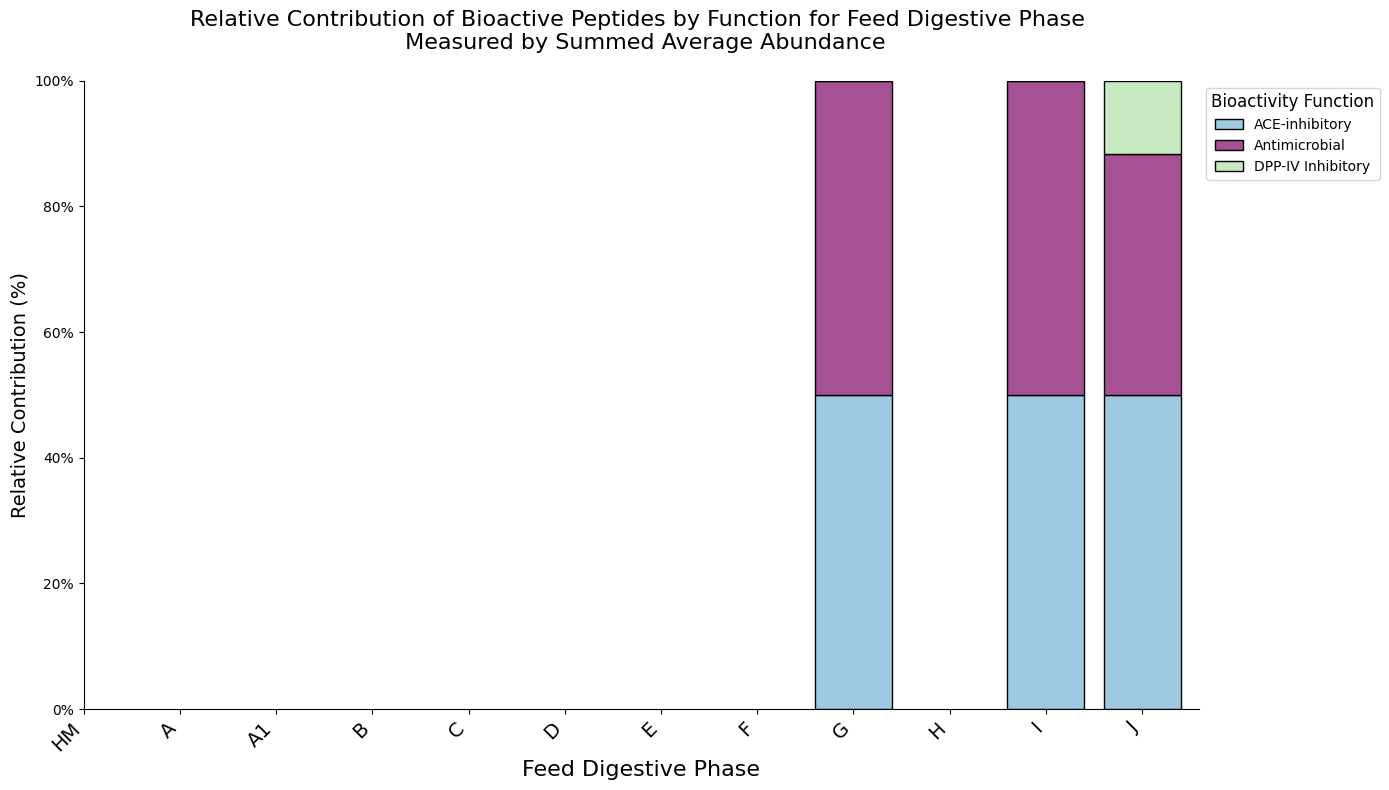

In [20]:
sample_order = ['HM_F', 'A_F', 'A1_F', 'B_F', 'C_F', 'D_F', 'E_F', 'F_F', 'G_F', 'H_F', 'I_F', 'J_F']

# Filter the filtered_sums dictionary to only include samples in sample_order
#filtered_sums_filtered = {sample: biofunctions for sample, biofunctions in filtered_sums_renamed.items() if sample in sample_order}
filtered_sums_filtered = combined_abundance_df_fordisplay[sample_order]
filtered_sums_filtered.columns = filtered_sums_filtered.columns.str.replace(r'_F$', '', regex=True)

# Now you can plot the filtered data
plot_name = "Feed"
figsize = (14, 8)

plot_stacked_bioactive_peptides(filtered_sums_filtered, figsize, plot_name)

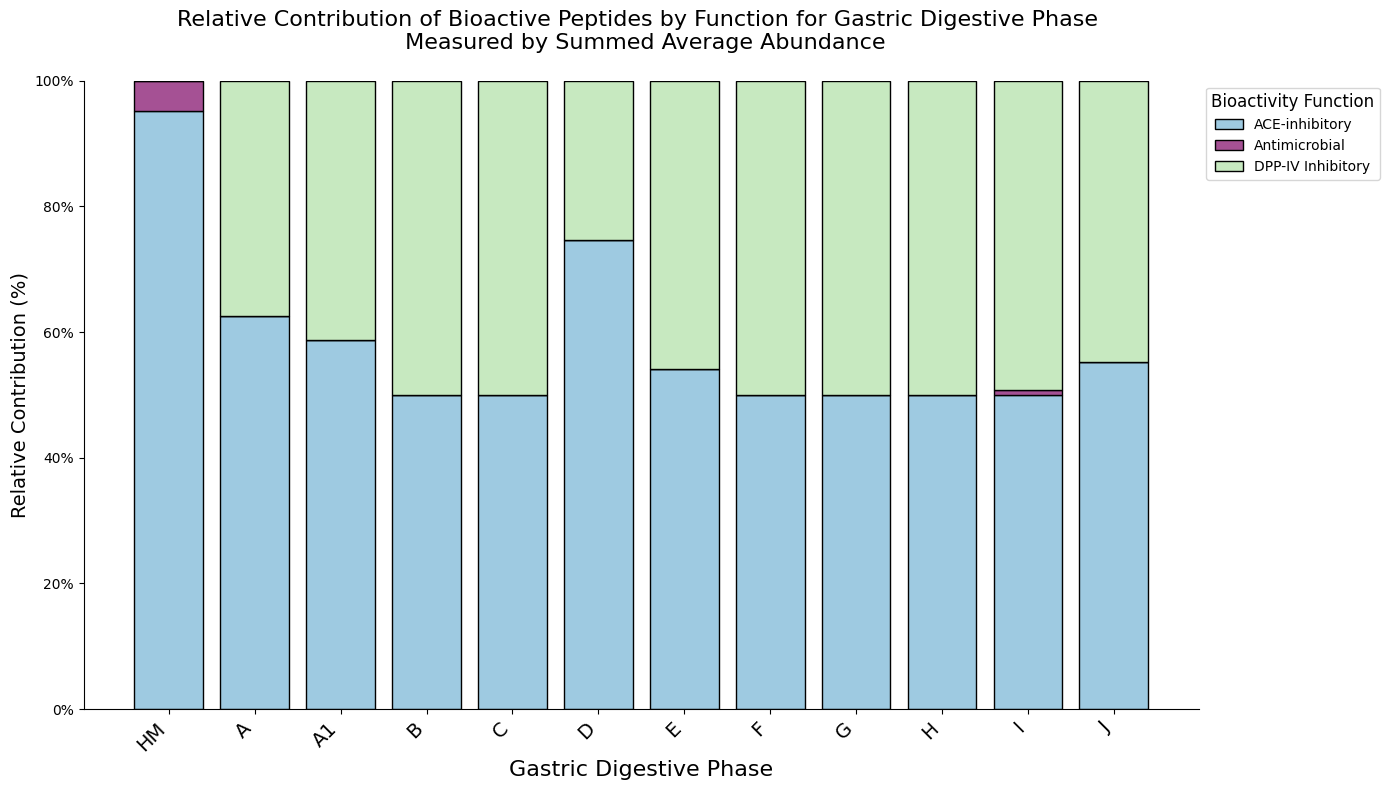

In [21]:

sample_order = ['HM_G', 'A_G', 'A1_G', 'B_G', 'C_G', 'D_G', 'E_G', 'F_G', 'G_G', 'H_G', 'I_G', 'J_G']

# Filter the filtered_sums dictionary to only include samples in sample_order
filtered_sums_filtered = combined_abundance_df_fordisplay[sample_order]
# Now you can plot the filtered data
plot_name = "Gastric"
figsize = (14, 8)
filtered_sums_filtered.columns = filtered_sums_filtered.columns.str.replace(r'_G$', '', regex=True)

plot_stacked_bioactive_peptides(filtered_sums_filtered, figsize, plot_name)


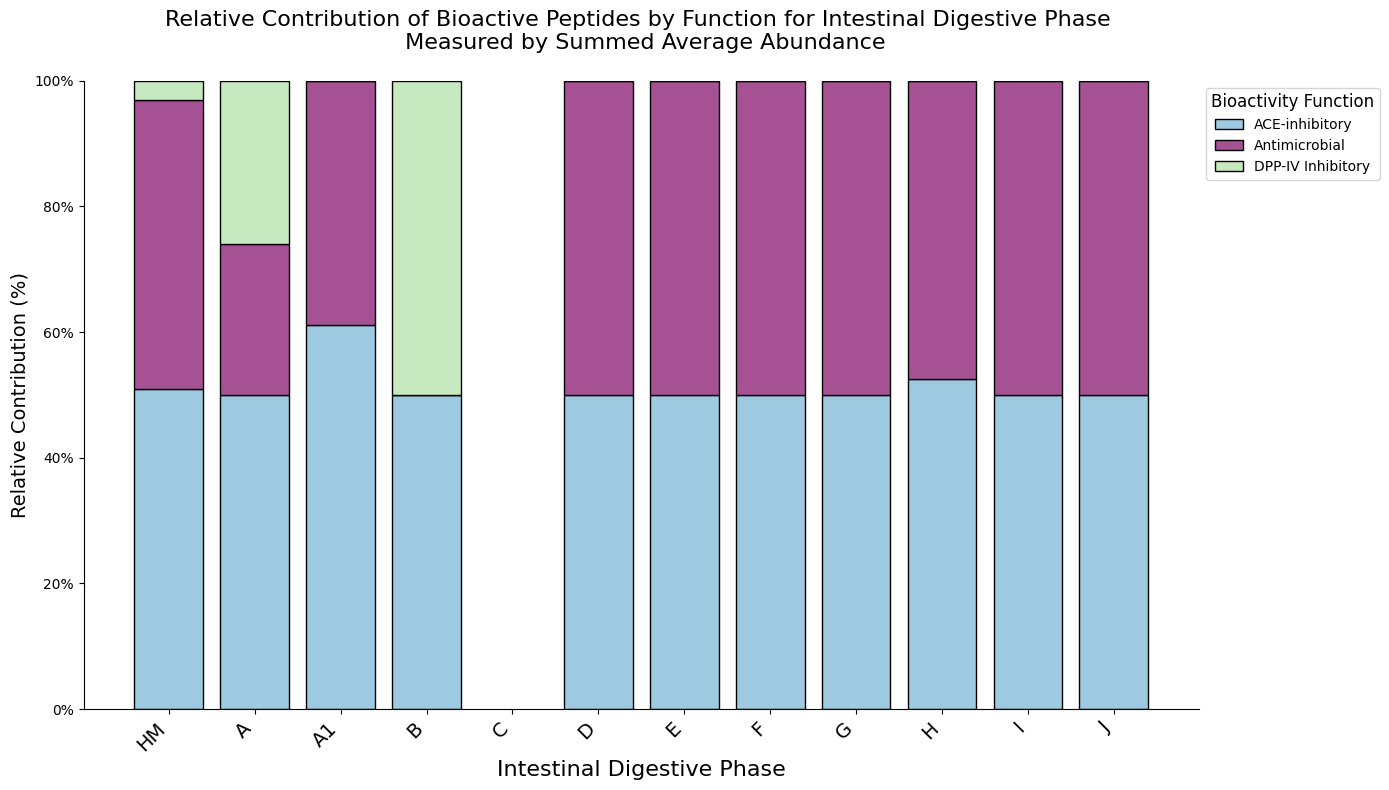

In [22]:
sample_order = ['HM_I', 'A_I','A1_I', 'B_I', 'C_I', 'D_I', 'E_I', 'F_I', 'G_I', 'H_I', 'I_I', 'J_I']

# Filter the filtered_sums dictionary to only include samples in sample_order
filtered_sums_filtered = combined_abundance_df_fordisplay[sample_order]
# Now you can plot the filtered data
plot_name = "Intestinal"
figsize = (14, 8)
filtered_sums_filtered.columns = filtered_sums_filtered.columns.str.replace(r'_I$', '', regex=True)

plot_stacked_bioactive_peptides(filtered_sums_filtered, figsize, plot_name)


# Stacked Bar Plots for Summed Abundance

In [27]:

def plot_bioactive_peptides(df, figsize, plot_name, sample_order):
    output_dir = f'/home/kuhfeldrf/ds_scripts/abbott/bioactive_bar_plots'
    os.makedirs(output_dir, exist_ok=True)
    
    # Prepare data
    functions = df['function'].unique()
    plot_data = {func: [0] * len(sample_order) for func in functions}  # Initialize with zeroes
    
    # Populate plot_data with actual absorbance values if they exist
    for idx, sample in enumerate(sample_order):
        stage_data = df[df['sample'] == sample]
        for func in functions:
            absorbance = stage_data[stage_data['function'] == func]['absorbance'].values
            plot_data[func][idx] = absorbance[0] if len(absorbance) > 0 else 0
    
    # Constants for the plot
    num_categories = len(plot_data)  # Number of peptide types
    total_width = 0.8  # Total width for all bars at one x position
    single_width = total_width / num_categories  # Width of each bar
    x = np.arange(len(sample_order))  # the label locations

    colors = [color_mapping.get(function) for function in functions]
    labels = list(plot_data.keys())
    
    # Plotting setup
    fig, ax = plt.subplots(figsize=figsize)

    # Create bars for each peptide type, plotting all samples with zeros if necessary
    for i, (func, absorbance) in enumerate(plot_data.items()):
        position = x - total_width / 2 + i * single_width + single_width / 2
        if num_categories > 10:
            bars = ax.bar(position, absorbance, width=single_width, label=labels[i], color=colors[i])
        else:
            bars = ax.bar(position, absorbance, width=single_width, label=labels[i], color=colors[i], edgecolor='black')
    
    # Formatting the plot
    ax.set_ylabel("Summed Averaged Abundance (Log10)", fontsize=16)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    min_values = min(df['absorbance'].dropna())
    max_values = max(df['absorbance'].dropna())
    max_yvalues = 10 ** np.ceil(np.log10(max_values))
    min_yvalues = 10 ** np.floor(np.log10(min_values))

    # Set x-ticks and align labels
    stages = [re.sub(r"__.", "", item) for item in sample_order]
    stages = [re.sub(r"Human_Milk", "HM", item) for item in stages]
    stages = [re.sub(r"Control", "A", item) for item in stages]
    ax.set_xticks(x)
    ax.set_xticklabels(stages, rotation=45, ha='right', fontsize=14)
    plt.ylim(min_yvalues, max_yvalues)
    plt.yscale('log')
    plt.xlabel(f'{plot_name} Digestive Phase')
    
    # Add the legend
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, title='Bioactivity Function', fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

    # Style adjustments
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_color('#444444')
    plt.gca().spines['left'].set_color('#444444')
    
    #plt.suptitle(f'Summed Averaged Abundance of Bioactive Peptides within {plot_name} Digestive Phase', fontsize=16)
    fig.savefig(os.path.join(output_dir, f'{plot_name}_bioactive_bar_plot{f_selected_data}.png'), bbox_inches='tight')

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_5589/1482254929.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sample'] = pd.Categorical(filtered_df['sample'], categories=sample_order, ordered=True)


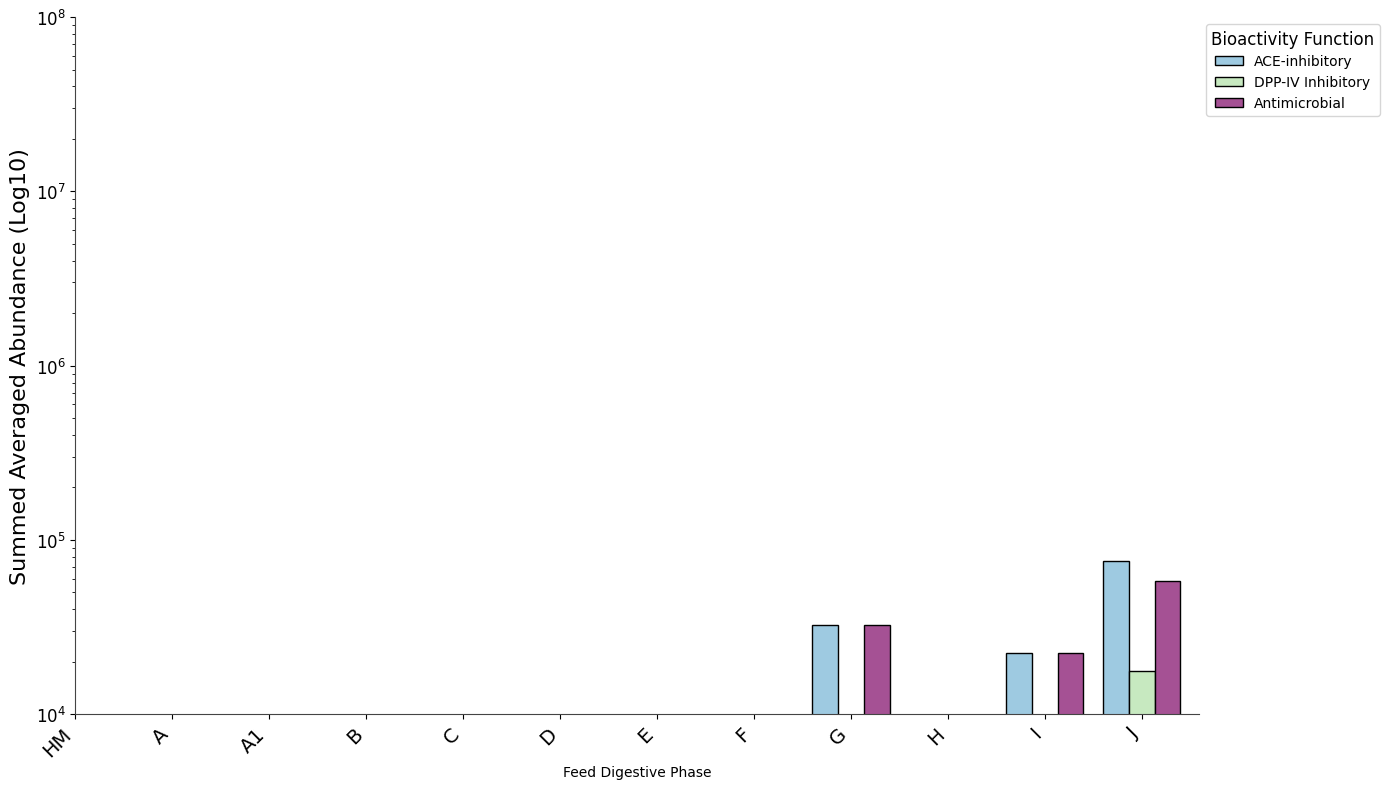

/tmp/ipykernel_5589/1482254929.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sample'] = pd.Categorical(filtered_df['sample'], categories=sample_order, ordered=True)


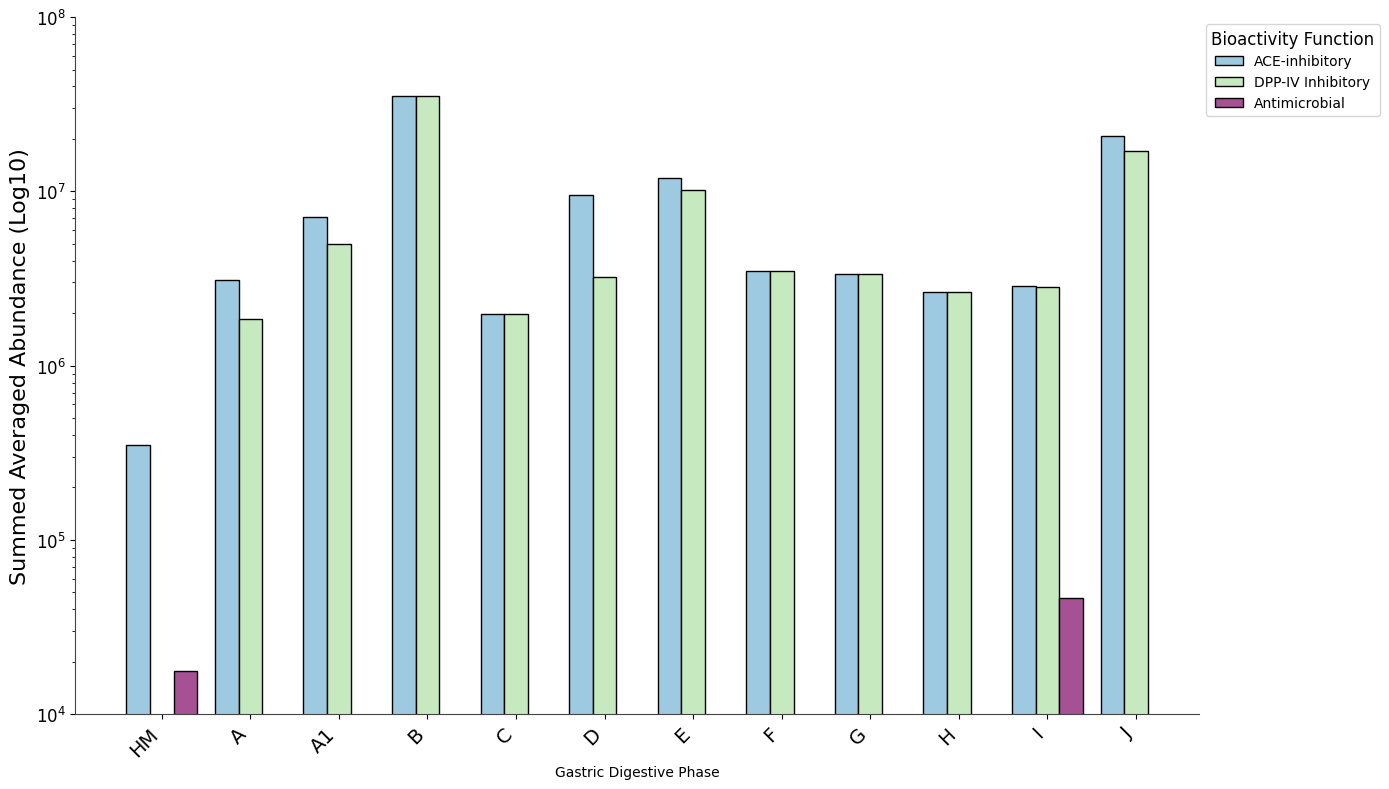

/tmp/ipykernel_5589/1482254929.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sample'] = pd.Categorical(filtered_df['sample'], categories=sample_order, ordered=True)


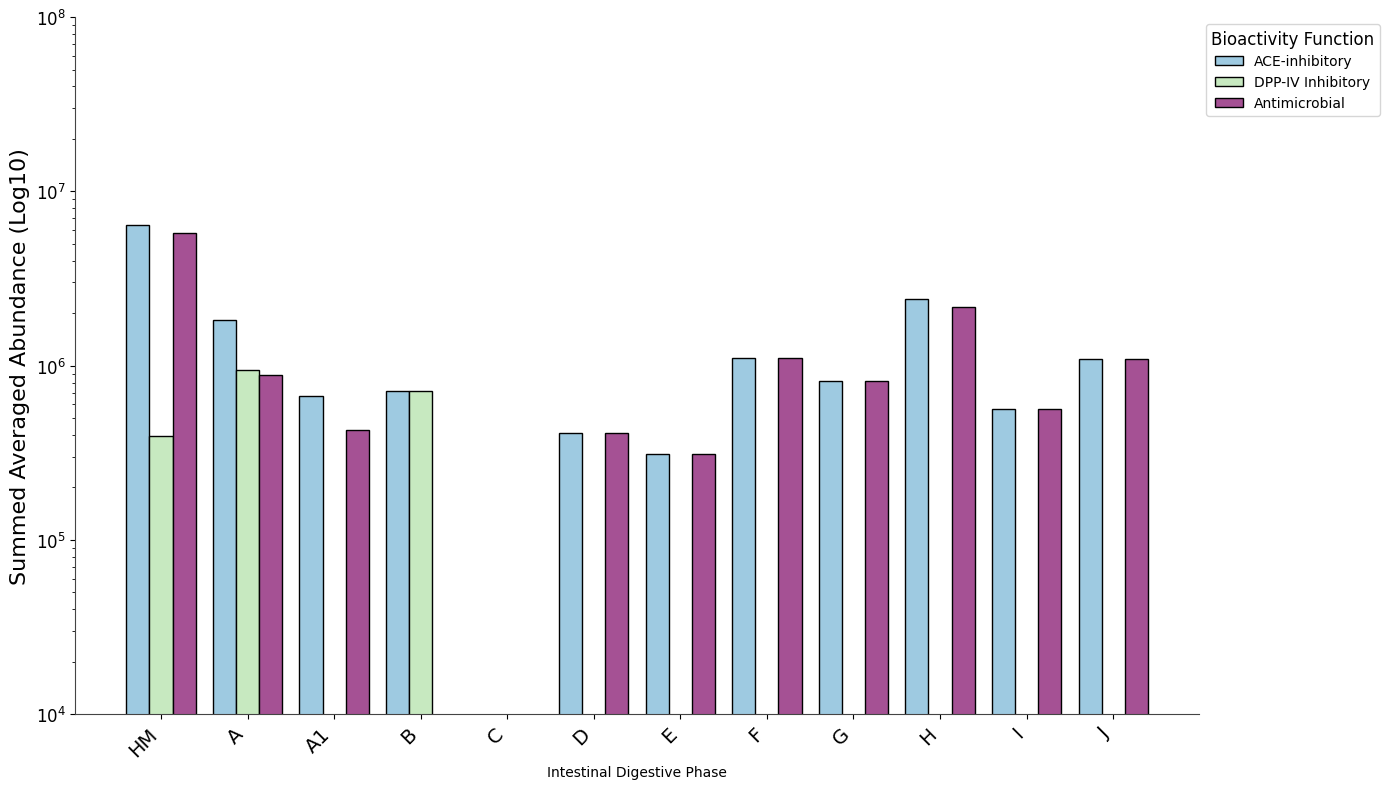

In [28]:
list1 = ['__F','__G','__I']
for p in list1:
    sample_order = [f'Human_Milk{p}',f'Control{p}',f'A1{p}',f'B{p}',f'C{p}',f'D{p}',f'E{p}',f'F{p}',f'G{p}',f'H{p}',f'I{p}',f'J{p}']
    
    # Filter the DataFrame for specific samples and reorder based on the defined order
    filtered_df = function_by_stage_df[
        function_by_stage_df['sample'].isin(sample_order)
    ]
    
    # Reorder the DataFrame by the 'sample' column according to the specified order
    filtered_df['sample'] = pd.Categorical(filtered_df['sample'], categories=sample_order, ordered=True)
    
    # Sort the DataFrame by 'sample' first and then by 'average' within each sample
    filtered_df = filtered_df.sort_values(['sample'], ascending=[True]).reset_index(drop=True)
    
    filtered_df = filtered_df[~filtered_df['sample'].str.contains('New_Formula')]
    
    #filtered_df = filtered_df[filtered_df['average']>=1]
    
    if p == '__F':
        plot_name = 'Feed'
    elif p == '__G':
        plot_name = 'Gastric'
    elif p == '__I':
        plot_name = 'Intestinal'
    figsize=(14, 8)
    plot_bioactive_peptides(filtered_df, figsize, plot_name, sample_order)

## Data prep for box plot

In [25]:
"""
sampletype_color = {
    'Control': '#005A9E',   # Lighter shade of blue
    'New_Formula': '#0072C6',  # Base blue
    'Human_Milk': '#6699CC'  # Darker shade of blue
}

output_dir = 'bioactive_bar_plots/'
df = combined_abundance_df_fordisplay.iloc[0]

# Convert the Series to a DataFrame for better handling of the sample names
df = df.reset_index()
df.columns = ['sample', 'Sum_Absorbance']

df = df[~df['sample'].isin(['Control', 'New_Formula', 'Human_Milk','New_Formula_Feed','New_Formula_Gastric','New_Formula_Intestinal'])]
sample_bases_names = {
    'Control': ['A', 'A1'],
    'Human_Milk': ['HM'],
    'New_Formula': ['A1', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
}
# Add the 'sample_type' column based on the sample_bases_names dictionary
def map_sample_type(sample):
    # Extract the base part before the first underscore
    base_name = sample.split('_')[0]
    # Match the base name to its corresponding sample type
    for sample_type, bases in sample_bases_names.items():

        # Handle Human Milk and Control explicitly
        if base_name == 'Human':
            base_name = 'HM'
        elif base_name == 'Control':
            base_name = 'A'
        elif base_name == 'Control':
            base_name = 'A'
        if base_name in bases:
            return sample_type    
    return 'Unknown'  # Fallback in case of no match


# Add the 'Digestive_Phase' column based on the text after the last underscore
def extract_digestive_phase(sample):
    # Extract the phase part (Intestinal, Feed, or Gastric) from the sample name
    if '_' in sample:
        return sample.split('_')[-1]
    return 'Unknown'  # Fallback in case of no match
    
# Define the abbreviations for each digestive phase
digestive_phase_abbreviations = {
    'Intestinal': '_I',
    'Feed': '_F',
    'Gastric': '_G'
}

# Function to extract the base sample ID
def extract_base_sample_id(sample):
    # Extract the base name (the part before the first underscore)
    base_name = sample.split('_')[0]
    
    # Handle Human Milk and Control explicitly
    if base_name == 'Human':
        base_name = 'HM'
    elif base_name == 'Control':
        base_name = 'A'
    
    # Extract the digestive phase abbreviation
    phase = extract_digestive_phase(sample)  # Use the function defined previously
    phase_abbreviation = digestive_phase_abbreviations.get(phase, '')

    # Combine the base name with the phase abbreviation
    return f"{base_name}"#{phase_abbreviation}"

# Add the 'Base_Sample_ID' column
df['Base_Sample_ID'] = df['sample'].apply(extract_base_sample_id)
df['Sample_Type'] = df['sample'].apply(map_sample_type)
df['Digestive_Phase'] = df['sample'].apply(extract_digestive_phase)

# Find min and max for y-axis limit
min_values = min(df['Sum_Absorbance'])
max_values = max(df['Sum_Absorbance'])

max_yvalues = 10 ** np.ceil(np.log10(max_values))
title_label = 'Summed Average Abundance (log10)'
min_yvalues = 10 ** np.floor(np.log10(min_values))

max_y_values = max_yvalues #df['Sum_Absorbance'].groupby('sample').max()
for phase in set(df['Digestive_Phase']):
    df_filtered = df[df['Digestive_Phase']==phase]
    

    
    # Define the patterns for each digestive phase
    #digestive_phase_patterns = {'Feed': '', 'Gastric': '/', 'Intestinal': '.'}
    
    # Create a new figure for the combined plot
    plt.figure(figsize=(16, 12))
    # Plot the grouped data with error bars
    for sample_type, group_data_df in df_filtered.groupby('Sample_Type'):

        # Select the appropriate color
        color = sampletype_color[sample_type]
        
        # Loop over each digestive phase and plot
        for phase, phase_data_df in group_data_df.groupby('Digestive_Phase'):
            # Select the appropriate hatch pattern
            #hatch = digestive_phase_patterns.get(phase, '')
            
            # Plot the bars for each phase
            plt.bar(
                x=phase_data_df['Base_Sample_ID'], 
                height=phase_data_df['Sum_Absorbance'], 
                color=color, 
                edgecolor='black', 
                #hatch=hatch, 
                capsize=4, 
                error_kw={'elinewidth': 1, 'ecolor': 'black'}
            )
        
    # Legend and formatting\
    legend_saturation = [Patch(facecolor=color, label=label) for label, color in sampletype_color.items()]
    #legend_digestive_phase = [Patch(facecolor='white', edgecolor='black', hatch=hatch, label=label) for label, hatch in digestive_phase_patterns.items()]
    
    plt.legend(handles=legend_saturation, 
                         title='Sample Type', 
                         loc='upper left',  # Specify location only once
                         fontsize=16, 
                         title_fontsize=18, 
                         bbox_to_anchor=(1, 1), 
                         ncol=1)    

    if phase == 'F':
        full_phase = 'Feed'
    elif phase == 'G':
        full_phase = 'Gastric'
    elif phase == 'I':
        full_phase = 'Intestinal'
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    
    # Set labels and title
    plt.xlabel(f"{full_phase} Digestive Phase", fontsize=18)
    plt.ylabel(f'{title_label}', fontsize=18)
    plt.ylim(min_yvalues, max_yvalues)

    plt.yscale('log')
    
    plt.xticks(rotation=45)
    plt.grid(axis='x', linestyle='', which='both')
    plt.tick_params(axis='both', which='both', bottom=True, left=True, labelbottom=True, labelleft=True, labelsize=11)

    #plt.tight_layout(rect=[0, 0, 0.75, 1])

    #plt.title(f'Summed Average Abundances of Bioactive Peptides For {full_phase} Digestive Phase\n', fontsize=18)
    plt.title(f'Summed Average Abundances of Bioactive Peptides With Shared Alignment to Human Milk For {phase} Digestive Phase\n', fontsize=18)
    plt.savefig(os.path.join(output_dir,f"{phase}_Human_Aligned_Bioactive_Summed_Aberage_Abundance_Bar_plot.png"), bbox_inches='tight')
    #plt.savefig(os.path.join(output_dir,f"{full_phase}_Bioactive_Summed_Aberage_Abundance_Bar_plot.png"), bbox_inches='tight')
    plt.show()
""";

# Pie Charts

In [26]:
def plot_function_pie_charts(df, phase, ax=None, sample_column='sample', function_column='function', data_column='absorbance', colormap='tab20_r', figsize=(12, 8), font_size=10):
    """
    Plots pie charts of function distributions for each sample type in the DataFrame.

    Parameters:
    - df (DataFrame): The input DataFrame containing 'sample', 'function', and 'count' columns.
    - ax (matplotlib.axes._subplots.AxesSubplot): The axes on which to draw the pie chart. Default is None.
    - sample_column (str): The name of the column containing sample types. Default is 'sample'.
    - function_column (str): The name of the column containing function names. Default is 'function'.
    - data_column (str): The name of the column containing function counts. Default is 'count'.
    - colormap (str): The name of the colormap to use for the pie chart. Default is 'tab20_r'.
    - figsize (tuple): The size of the figure to plot. Default is (12, 8).
    """
    df = process_function_percentages(df, sample_column='sample', function_column='function', data_column='absorbance', threshold=1)
    # Aggregate the counts by function
    function_counts_aggregated = df.groupby(function_column)[data_column].sum().reset_index()

    # Separate the "Minor Functions (<1%)" row
    other_row = function_counts_aggregated[function_counts_aggregated[function_column] == 'Minor Functions (<1%)']
    function_counts_aggregated = function_counts_aggregated[function_counts_aggregated[function_column] != 'Minor Functions (<1%)']
    function_counts_aggregated = function_counts_aggregated.sort_values(by=data_column, ascending=False)
    function_counts_aggregated = pd.concat([function_counts_aggregated, other_row], ignore_index=True)

    # Plot the pie chart
    if ax is None:
        ax = plt.gca()
    

    # Define the full list of functions (for consistency across all samples)
    full_function_list = list(color_mapping.keys())

    # Get the subset of functions present in the current sample and their colors
    functions = function_counts_aggregated[function_column].tolist()
    colors = [color_mapping.get(function) for function in functions]

    wedges, texts, autotexts = ax.pie(
        function_counts_aggregated[data_column], 
        labels=function_counts_aggregated[function_column], 
        autopct=lambda pct: f'{pct:.1f}%' if pct >= 1 else '', 
        startangle=180, 
        pctdistance=0.9, 
        colors=colors
    )
    for autotext in autotexts:
        autotext.set_fontsize(font_size)  # Decrease the font size inside the pie chart

    ax.axis('equal')
    ax.set_xlabel(f'{phase}', labelpad=18)  # Adjust labelpad to decrease space between label and plot

def plot_combined_pie_charts(df, sample_bases, digestive_phase_mapping, sample_column='sample', function_column='function', data_column='absorbance', colormap='tab20_r', figsize=(18, 6), title_y=1.05, font_size=12):
    output_dir = f'{project_dir}pie_chart'
    os.makedirs(output_dir, exist_ok=True)

    for sample_list in sample_bases.values():
        for sample in sample_list:
            if sample == 'A':
                sample = 'Control'
            if sample == 'HM':
                sample = 'Human_Milk'
            fig, axes = plt.subplots(1, 3, figsize=figsize)
            for ax, phase in zip(axes, digestive_phase_mapping.keys()):
                sample_with_phase = f'{sample}_{phase}'
                sample_df = df[df[sample_column] == sample_with_phase]

                if sample_df.empty:
                    ax.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                else:
                    phase_label = digestive_phase_mapping[phase]  # Get the value associated with the phase key
                    plot_function_pie_charts(sample_df, phase_label, ax=ax, sample_column=sample_column, function_column=function_column, data_column=data_column, colormap=colormap, font_size=font_size)

            plt.tight_layout(rect=[0, 0, 1, 1], pad=0)  # Adjust pad to decrease space between title and plots
            plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1)  # Adjust these to reduce margins
            if sample == 'Control':
                sample = 'A'
            if sample == 'Human_Milk':
                sample = 'HM'
            # Add the title after tight_layout
            #plt.suptitle(f'Bioactive Peptide Function Distribution for Sample {sample} With Shared Alignment to Human Milk Across Digestive Phases', fontsize=16, y=title_y)
            #fig.savefig(os.path.join(output_dir, f'Human_Aligned{sample}_combined_pie_chart.png'), bbox_inches='tight')

            plt.suptitle(f'Bioactive Peptide Function Distribution for Sample {sample} Across Digestive Phases', fontsize=16, y=title_y)
            fig.savefig(os.path.join(output_dir, f'Abbott_Classification_{sample}_combined_pie_chart.png'), bbox_inches='tight')
            plt.show()

            plt.close(fig)


plot_combined_pie_charts(function_by_stage_df, sample_bases, digestive_phase_mapping, sample_column='sample', function_column='function', data_column='absorbance', colormap='tab20_r', figsize=(18, 6), title_y=1.05, font_size=10)
    

/home/kuhfeldrf/miniforge3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3290: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 1800x600 with 3 Axes>

# Individual Huamn and Bovine Bioactive Peptide Analysis

### Filtering of lists

In [ ]:
def count_and_percentage_non_nan_values(df, select_cols, title):
    # Count non-NaN values in the specified columns
    non_nan_counts = df[select_cols].apply(lambda row: row.count(), axis=1)
    
    # Calculate the percentage of non-NaN values for each row
    total_columns = len(select_cols)
    percentage_non_nan = (non_nan_counts / total_columns) * 100
    my_list = [
    'Master Protein Accessions', 
    'Positions in Proteins', 
    'Confidence', 
    'Quan Info', 
    'unique ID', 
    'Function',
    'Search peptide',
    'Peptide',
    'Protein ID',
    'Protein description',
    '% Alignment',
    'Species',
    'Intervals',
    'Average_Abundance_Human_Milk',
    'Average_Abundance_Control',
    'Average_Abundance_New_Formula',
    'Average_Abundance_Human_Milk_Intestinal',
    'Average_Abundance_Human_Milk_Gastric',
    'Average_Abundance_Human_Milk_Feed',
    'Average_Abundance_Control_Feed',
    'Average_Abundance_Control_Gastric',
    'Average_Abundance_Control_Intestinal',
    'Average_Abundance_New_Formula_Feed',
    'Average_Abundance_New_Formula_Gastric',
    'Average_Abundance_New_Formula_Intestinal',
    'Average_Abundance_A1_Feed',
    'Average_Abundance_A1_Gastric',
    'Average_Abundance_A1_Intestinal',
    'Average_Abundance_B_Feed',
    'Average_Abundance_B_Gastric',
    'Average_Abundance_B_Intestinal',
    'Average_Abundance_C_Feed',
    'Average_Abundance_C_Gastric',
    'Average_Abundance_C_Intestinal',
    'Average_Abundance_D_Feed',
    'Average_Abundance_D_Gastric',
    'Average_Abundance_D_Intestinal',
    'Average_Abundance_E_Feed',
    'Average_Abundance_E_Gastric',
    'Average_Abundance_E_Intestinal',
    'Average_Abundance_F_Feed',
    'Average_Abundance_F_Gastric',
    'Average_Abundance_F_Intestinal',
    'Average_Abundance_G_Feed',
    'Average_Abundance_G_Gastric',
    'Average_Abundance_G_Intestinal',
    'Average_Abundance_H_Feed',
    'Average_Abundance_H_Gastric',
    'Average_Abundance_H_Intestinal',
    'Average_Abundance_I_Feed',
    'Average_Abundance_I_Gastric',
    'Average_Abundance_I_Intestinal',
    'Average_Abundance_J_Feed',
    'Average_Abundance_J_Gastric',
    'Average_Abundance_J_Intestinal'
    ]

    # Create a new DataFrame with the counts and percentages
    
    result_df = df[my_list].copy()
    count_name = f'{title}_Count'
    percentage_name = f'{title}_Percentage'
    result_df[count_name] = non_nan_counts
    result_df[percentage_name] = percentage_non_nan.round(2)
    
    # Sort the DataFrame by the Percentage Non-NaN in descending order
    result_df = result_df.sort_values(by=percentage_name, ascending=False)
    
    return result_df

bovine_samples = ['A1_F', 'A1_G', 'A1_I', 'A2_F', 'A2_G', 'A2_I', 'A3_F', 'A3_G', 'A3_I', 'A1_1_F', 'A1_2_F', 'A1_3_F', 
                  'A1_1_G', 'A1_2_G', 'A1_3_G', 'A1_1_I', 'A1_2_I', 'A1_3_I', 'B1_F', 'B1_G', 'B1_I', 'B2_F', 'B2_G', 
                  'B2_I', 'B3_F', 'B3_G', 'B3_I', 'C1_F', 'C1_G', 'C1_I', 'C2_F', 'C2_G', 'C2_I', 'C3_F', 'C3_G', 'C3_I', 
                  'D1_F', 'D1_G', 'D1_I', 'D2_F', 'D2_G', 'D2_I', 'D3_F', 'D3_G', 'D3_I', 'E1_F', 'E1_G', 'E1_I', 'E2_F', 
                  'E2_G', 'E2_I', 'E3_F', 'E3_G', 'E3_I', 'F1_F', 'F1_G', 'F1_I', 'F2_F', 'F2_G', 'F2_I', 'F3_F', 'F3_G', 
                  'F3_I', 'G1_F', 'G1_G', 'G1_I', 'G2_F', 'G2_G', 'G2_I', 'G3_F', 'G3_G', 'G3_I', 'H1_F', 'H1_G', 'H1_I', 
                  'H2_F', 'H2_G', 'H2_I', 'H3_F', 'H3_G', 'H3_I', 'I1_F', 'I1_G', 'I1_I', 'I2_F', 'I2_G', 'I2_I', 'I3_F', 
                  'I3_G', 'I3_I', 'J1_F', 'J1_G', 'J1_I', 'J2_F', 'J2_G', 'J2_I', 'J3_F', 'J3_G', 'J3_I']


# Assuming all_abs_col is a list of column names in your DataFrame for which you want to count non-NaN values
Bovine_percent_result_df = count_and_percentage_non_nan_values(mbpdb_merged_filteredbyhuman_df, bovine_samples, "Bovine")
Control_percent_result_df = count_and_percentage_non_nan_values(mbpdb_merged_filteredbyhuman_df, group_data['1']['abundance_columns'], "Control")
#human_milk_cols = list(])
# Example usage:
# Assuming all_abs_col is a list of column names in your DataFrame for which you want to count non-NaN values
human_milk_aligned_result_df = count_and_percentage_non_nan_values(mbpdb_merged_filteredbyhuman_df,group_data['3']['abundance_columns'], 'Human_aligned')

human_milk_aligned_result_df

## Finds counts and percent within each group

In [ ]:
def count_and_percentage_non_nan_values_grouped(df, group_data):
    # Start with a copy of the DataFrame that retains the key columns
    retained_columns = [
        'Marked as',
        'Master Protein Accessions', 
        'Positions in Proteins', 
        
        'Confidence', 
        'Quan Info', 
        'unique ID', 
        'Function',
        'Search peptide',
        'Peptide',
        'Protein ID',
        'Protein description',
        '% Alignment',
        'Species',
        'Intervals',
    ]
    
    result_df = df[retained_columns].copy()
    
    # Iterate through each group in group_data
    for group_key, group_info in group_data.items():
        grouping_variable = group_info['grouping_variable']
        abundance_columns = group_info['abundance_columns']
        
        # Count non-NaN values in the abundance columns
        non_nan_counts = df[abundance_columns].apply(lambda row: row.count(), axis=1)
        
        # Calculate the percentage of non-NaN values for each row
        total_columns = len(abundance_columns)
        percentage_non_nan = (non_nan_counts / total_columns) * 100
        
        # Create count and percentage column names based on the group
        count_name = f'{grouping_variable}_Count'
        percentage_name = f'{grouping_variable}_Percentage'
        
        # Add the count and percentage columns to the result DataFrame
        result_df[count_name] = non_nan_counts
        result_df[percentage_name] = percentage_non_nan.round(2)
    
    # Return the final DataFrame with count and percentage columns for each group
    return result_df

# Example usage
all_samples_percent_result_df = count_and_percentage_non_nan_values_grouped(mbpdb_merged_filteredbyhuman_df, group_data)


## Matching bioactive peptides found in human and bovine data

In [ ]:
matching_threshold = 0


All_percent_result_df_humanandbovine = Bovine_percent_result_df[Bovine_percent_result_df['Bovine_Percentage'] >= matching_threshold]
#All_percent_result_df_humanandbovine = Control_percent_result_df[Control_percent_result_df['Control_Percentage'] >= matching_threshold]


# 10 out of 12 human milk samples = 83%
human_milk_aligned_result_df_humanandbovine = human_milk_aligned_result_df[human_milk_aligned_result_df['Human_aligned_Percentage'] >= matching_threshold]

matching_df = pd.merge(human_milk_aligned_result_df_humanandbovine, All_percent_result_df_humanandbovine, on='unique ID', how='left')
matching_ids = set(human_milk_aligned_result_df_humanandbovine['unique ID']).intersection(set(All_percent_result_df_humanandbovine['unique ID']))
# Drop or rename unnecessary columns
matching_df.rename(columns={
    'Master Protein Accessions_x': 'Master Protein Accessions',
    'Positions in Proteins_x': 'Positions in Proteins',
    'Function_x': 'Function'
}, inplace=True)

# Optionally drop duplicate columns from the merge
matching_df.drop(columns=[
    'Master Protein Accessions_y',	'Positions in Proteins_y',	'Function_y'], inplace=True)

# Assuming matching_ids is a set of unique IDs that match between both DataFrames
filtered_matching_df = matching_df[matching_df['unique ID'].isin(matching_ids)]

# Remove all columns with '_y' in their name
filtered_matching_df = filtered_matching_df.loc[:, ~filtered_matching_df.columns.str.contains('_y')]

# Rename columns with '_x' by removing the suffix
filtered_matching_df.columns = filtered_matching_df.columns.str.replace('_x', '', regex=False)

filtered_matching_df_no_duplicates = filtered_matching_df.drop_duplicates(subset=['Master Protein Accessions', 'Positions in Proteins', 'unique ID'], keep='first')

#filtered_matching_df.to_csv(f'{project_dir}data_summary_export/all_Human_aligned_bioactive_peptides.csv', index=False)

# Display the resulting DataFrame

In [ ]:
pd.set_option('display.max_rows', 20)  # Display all columns without truncation
pd.set_option('display.max_columns', 20)  # Display all columns without truncation
filtered_matching_df_no_duplicates

## Filter and display bioactive peptide matches that align to both human and bovine 

In [ ]:

# Remove BLG as its not a human protein 
human_bovine_matches = all_samples_percent_result_df[all_samples_percent_result_df['Marked as']=='Bovine;Human']
human_bovine_matches
#uman_bovine_matches[['unique ID','Peptide','% Alignment']]


In [ ]:
# Digestive phase mapping
digestive_phase_mapping = {'_F': 'Feed', '_G': 'Gastric', '_I': 'Intestinal'}

# Replace NaN values with zero in the human_bovine_matches DataFrame
human_bovine_matches_filled = human_bovine_matches.fillna(0)

# Remove columns that contain 'New'
no_new = [col for col in human_bovine_matches_filled.columns if 'New' not in col]
human_bovine_matches_updated = human_bovine_matches_filled[no_new]

# Extract the relevant columns for each phase
feed_columns = [col for col in human_bovine_matches_updated.columns if '_Feed' in col]
gastric_columns = [col for col in human_bovine_matches_updated.columns if '_Gastric' in col]
intestinal_columns = [col for col in human_bovine_matches_updated.columns if '_Intestinal' in col]
"""

# Strip 'Average_Abundance' and digestive phase from the x-axis labels (keeping only sample base ID),
# and relabel 'Human_Milk' as 'HM' and 'Control' as 'A'

# Function to plot the chart for each phase
def plot_phase(phase_columns, phase_name, title):
    sample_base_ids = get_sample_base_ids(phase_columns)

    # Create figure and axis for grouped bar plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set up plot for multiple bar chart
    peptides = human_bovine_matches_updated['unique ID'].unique()  # unique peptides
    x = np.arange(len(phase_columns))  # x locations for abundance columns
    width = 0.2  # width of the bars

    # Plot bars for each peptide (unique ID)
    for i, peptide in enumerate(peptides):
        # Extract the values for this peptide for each abundance column
        peptide_values = human_bovine_matches_updated[human_bovine_matches_updated['unique ID'] == peptide][phase_columns].values[0]

        # Plot the bars for this peptide
        ax.bar(x + i * width, peptide_values, width, label=peptide)  # legend will show the peptide

    # Set the labels for the x-axis (sample base IDs)
    ax.set_xticks(x + width * (len(peptides) / 2))
    ax.set_xticklabels(sample_base_ids)

    # Set the log scale for the y-axis
    ax.set_yscale('log')

    # Set labels and title
    ax.set_xlabel('Sample Base IDs')
    ax.set_ylabel('Average Abundance (Log Scale)')
    ax.set_title(title)
    ax.legend(title='Matching Peptides')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot for each phase
plot_phase(feed_columns, 'Feed', 'Average Abundance by Peptide for Feed Phase')
plot_phase(gastric_columns, 'Gastric', 'Average Abundance by Peptide for Gastric Phase')
plot_phase(intestinal_columns, 'Intestinal', 'Average Abundance by Peptide for Intestinal Phase')
""";

In [ ]:
human_bovine_matches_updated

In [ ]:

all_samples_percent_result_df.columns

In [ ]:

# Get the unique IDs from human_bovine_matches
unique_ids_to_match = list(set(human_bovine_matches['unique ID']))

# Filter rows in all_samples_percent_result_df where 'unique ID' is in the list
filtered_sums = all_samples_percent_result_df[all_samples_percent_result_df['unique ID'].isin(unique_ids_to_match)]

# Remove columns that contain 'New'
no_new = [col for col in filtered_sums.columns if 'New' not in col]
filtered_sums = filtered_sums[no_new]

filtered_sums.to_csv(f'{project_dir}data_summary_export/all_Human_aligned_bioactive_peptides_matchs_count_and_percentage_witin_each_sample.csv', index=False)

# Extract the relevant columns for each phase
feed_columns_within = [col for col in filtered_sums.columns if '_Feed_Percentage' in col]
gastric_columns_within = [col for col in filtered_sums.columns if '_Gastric_Percentage' in col]
intestinal_columns_within = [col for col in filtered_sums.columns if '_Intestinal_Percentage' in col]

"""

# Modify sample base IDs function to work with percentage columns
# Modify sample base IDs function to work with percentage columns
def get_sample_per_base_ids(columns):
    base_ids = [col.replace('_Percentage', '').replace('_Feed', '').replace('_Gastric', '').replace('_Intestinal', '') 
                for col in columns]
    return [col.replace('Human_Milk', 'HM').replace('Control', 'A') for col in base_ids]

# Modified function to plot percentages for each phase
def plot_phase_percent(phase_columns, phase_name, title):
    sample_base_ids = get_sample_per_base_ids(phase_columns)

    # Create figure and axis for grouped bar plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set up plot for multiple bar chart
    peptides = filtered_sums['unique ID'].unique()  # unique peptides
    x = np.arange(len(phase_columns))  # x locations for percentage columns
    width = 0.2  # width of the bars

    # Plot bars for each peptide (unique ID)
    for i, peptide in enumerate(peptides):
        # Extract the percentage values for this peptide for each column
        peptide_values = filtered_sums[filtered_sums['unique ID'] == peptide][phase_columns].values[0]

        # Plot the bars for this peptide
        ax.bar(x + i * width, peptide_values, width, label=peptide)  # legend will show the peptide


    # Set the labels for the x-axis (sample base IDs)
    ax.set_xticks(x + width * (len(peptides) / 2))
    ax.set_xticklabels(sample_base_ids, rotation=45, ha="right")

    # Set labels and title
    ax.set_xlabel('Sample Base IDs')
    ax.set_ylabel('Percentage of Non-NaN Values')
    ax.set_title(title)
    ax.legend(title='Matching Peptides')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot for each phase using percentage columns
plot_phase_percent(feed_columns_within, 'Feed', 'Percentage of Non-NaN Values by Peptide for Feed Phase')
plot_phase_percent(gastric_columns_within, 'Gastric', 'Percentage of Non-NaN Values by Peptide for Gastric Phase')
plot_phase_percent(intestinal_columns_within, 'Intestinal', 'Percentage of Non-NaN Values by Peptide for Intestinal Phase')
""";

In [ ]:
def get_sample_base_ids(columns):
    base_ids = [col.replace('Average_Abundance_', '').replace('_Feed', '').replace('_Gastric', '').replace('_Intestinal', '') 
                for col in columns]
    return [col.replace('Human_Milk', 'HM').replace('Control', 'A') for col in base_ids]
# Modify sample base IDs function to work with percentage columns
def get_sample_per_base_ids(columns):
    base_ids = [col.replace('_Percentage', '').replace('_Feed', '').replace('_Gastric', '').replace('_Intestinal', '') 
                for col in columns]
    return [col.replace('Human_Milk', 'HM').replace('Control', 'A') for col in base_ids]

import matplotlib.pyplot as plt
import numpy as np

# Modified function to create two subplots: one for average abundance, the other for percentage
def plot_phase_with_subplots(phase_columns_abundance, phase_columns_percentage, phase_name, title_abundance, title_percentage):
    output_dir = f'{project_dir}matching_bioactive_bar_plots'
    os.makedirs(output_dir, exist_ok=True)
    sample_base_ids_abundance = get_sample_base_ids(phase_columns_abundance)
    sample_base_ids_percentage = get_sample_per_base_ids(phase_columns_percentage)

    # Create figure and axis for two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # First subplot: Average Abundance (log scale)
    peptides = human_bovine_matches_updated['unique ID'].unique()  # unique peptides
    x_abundance = np.arange(len(phase_columns_abundance))  # x locations for abundance columns
    width = 0.2  # width of the bars

    for i, peptide in enumerate(peptides):
        # Extract values for average abundance for this peptide
        peptide_values_abundance = human_bovine_matches_updated[human_bovine_matches_updated['unique ID'] == peptide][phase_columns_abundance].values[0]
        ax1.bar(x_abundance + i * width, peptide_values_abundance, width, label=peptide, edgecolor='black')
    
    # Set the labels for the x-axis (sample base IDs for abundance)
    ax1.set_xticks(x_abundance + width * (len(peptides) / 2))
    ax1.set_xticklabels(sample_base_ids_abundance)

    # Set log scale and titles for abundance subplot
    ax1.set_yscale('log')
    ax1.set_xlabel('Sample Base IDs')
    ax1.set_ylabel('Average Abundance (Log Scale)')
    ax1.set_title(title_abundance)
    ax1.set_ylim(0, 10**8)

    # Remove top and right spines (pane lines)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Position the legend in the top right corner of the first plot
    ax1.legend(title='Matching Peptides', loc='upper left')

    # Second subplot: Percentage of Non-NaN values
    x_percentage = np.arange(len(phase_columns_percentage))  # x locations for percentage columns

    for i, peptide in enumerate(peptides):
        # Extract values for percentage for this peptide
        peptide_values_percentage = filtered_sums[filtered_sums['unique ID'] == peptide][phase_columns_percentage].values[0]
        ax2.bar(x_percentage + i * width, peptide_values_percentage, width, edgecolor='black')

    # Set the labels for the x-axis (sample base IDs for percentage)
    ax2.set_xticks(x_percentage + width * (len(peptides) / 2))
    ax2.set_xticklabels(sample_base_ids_percentage)

    # Set labels and title for percentage subplot
    ax2.set_xlabel('Sample Base IDs')
    ax2.set_ylabel('Percentage of Replicates with Detections')
    ax2.set_title(title_percentage)
    ax2.set_ylim(0, 100)

    # Remove top and right spines (pane lines)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    # Remove the legend from the second plot (percentage plot)
    ax2.legend().set_visible(False)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(output_dir, f'Human_Bovine_Bioactive_Peptide_Match_Combined_Bar_Plots_for_{phase_name}.png'), bbox_inches='tight')
    plt.close(fig)


# Example usage of the function
# Replace `human_bovine_matches_updated`, `feed_columns`, `feed_columns_within` with actual data
# plot_phase_with_subplots(feed_columns, feed_columns_within, 'Feed', 'Average Abundance Title', 'Percentage Title')


# Plot for each phase with two subplots (one for absorbance, one for percentage)
plot_phase_with_subplots(feed_columns, feed_columns_within, 'Feed', 'Average Abundance of Human-Bovine Aligned Bioactive Peptides for Feed Phase', f'Percentage Coverage of Human-Bovine Aligned Bioactive Peptide Detected Values \n Within Each Sample for Feed Phase')
plot_phase_with_subplots(gastric_columns, gastric_columns_within, 'Gastric', 'Average Abundance of Human-Bovine Aligned Bioactive Peptides for Gastric Phase', f'Percentage Coverage of Human-Bovine Aligned Bioactive Peptide Detected Values \n Within Each Sample for Gastric Phase')
plot_phase_with_subplots(intestinal_columns, intestinal_columns_within, 'Intestinal', 'Average Abundance of Human-Bovine Aligned Bioactive Peptides for Intestinal Phase', f'Percentage Coverage of Human-Bovine Aligned Bioactive Peptide Detected Values \n Within Each Sample for Intestinal Phase')


In [ ]:
function_by_stage_df

# Fold Change

In [29]:
combined_df = pd.DataFrame()
filtered_df = pd.DataFrame()
function_by_stage_df_mod = function_by_stage_df.copy()

# Replace values in 'sample' column
function_by_stage_df_mod['sample'] = function_by_stage_df_mod['sample'].str.replace(r'Human_Milk', 'HM', regex=True)
function_by_stage_df_mod['sample'] = function_by_stage_df_mod['sample'].str.replace(r'__', '_', regex=True)
function_by_stage_df_mod['sample'] = function_by_stage_df_mod['sample'].str.replace(r'Control', 'A', regex=True)

# Filter rows where 'sample' does not contain 'New_Formula' and does contain '_'
function_by_stage_df_mod = function_by_stage_df_mod[
    ~function_by_stage_df_mod['sample'].str.contains('New_Formula') & 
    function_by_stage_df_mod['sample'].str.contains('_')
]


#function_by_stage_df_mod = function_by_stage_df_mod.drop(columns=['sample'])
sample_orders = ['HM_F', 'HM_G', 'HM_I', 'A_F', 'A_G', 'A_I', 'A1_F', 'A1_G', 'A1_I', 
                'B_F', 'B_G', 'B_I', 'C_F', 'C_G', 'C_I', 'D_F', 'D_G', 'D_I', 
                'E_F', 'E_G', 'E_I', 'F_F', 'F_G', 'F_I', 'G_F', 'G_G', 'G_I',                 
                'H_F', 'H_G', 'H_I', 'I_F', 'I_G', 'I_I', 'J_F', 'J_G', 'J_I']

function_list = list(set(function_by_stage_df[function_by_stage_df['sample'] =='Human_Milk']['function']))

# Loop through each suffix and function
for suffix in suffixes:
    for func in function_list:
        # Determine the sample order based on the current suffix
        sample_order = [item for item in sample_orders if suffix in item]

        # Filter by function and suffix
        function_by_stage_df_mod_func = function_by_stage_df_mod[function_by_stage_df_mod['function'] == func]
        filtered_df = function_by_stage_df_mod_func[
            function_by_stage_df_mod_func['sample'].str.contains(f'{suffix}', regex=True)
        ].copy()

        # Reindex based on sample order
        filtered_df = filtered_df.set_index('sample').reindex(sample_order).reset_index()

        # Set the reference for 'Base ID Group 1' as 'HM_I' for this example
        filtered_df['Base ID Group 1'] = f'HM{suffix}'
        filtered_df['Base ID Group 2'] = filtered_df['sample']

        # Get the absorbance value of 'HM_I' for the current function
        hm_absorbance = filtered_df.loc[filtered_df['Base ID Group 2'] == f'HM{suffix}', 'absorbance'].values
        if hm_absorbance.size == 0:
            continue  # Skip if 'HM_I' is not found in the current function data
        hm_absorbance = hm_absorbance[0]

        # Calculate fold change and log2 fold change for each row in filtered_df
        for i, row in filtered_df.iterrows():
            sample_absorbance = row['absorbance']
            if hm_absorbance != 0 and sample_absorbance != 0:
                fold_change = sample_absorbance / hm_absorbance
                log2_fold_change = np.log2(fold_change)
            else:
                log2_fold_change = np.nan

            filtered_df.at[i, 'log2_fold_change_abs'] = log2_fold_change

        # Append the results to the combined DataFrame
        combined_df = pd.concat([combined_df, filtered_df], ignore_index=True)

# Save and display the results
combined_df.to_csv(f'data_summary_export/count_abs_l2fc_hm_df{f_selected_data}.csv', index=False)
combined_df

,sample,function,count,absorbance,Base ID Group 1,Base ID Group 2,log2_fold_change_abs
0,HM_F,ACE-inhibitory,NaN,NaN,HM_F,HM_F,NaN
1,A_F,ACE-inhibitory,NaN,NaN,HM_F,A_F,NaN
2,A1_F,ACE-inhibitory,NaN,NaN,HM_F,A1_F,NaN
3,B_F,ACE-inhibitory,NaN,NaN,HM_F,B_F,NaN
4,C_F,ACE-inhibitory,NaN,NaN,HM_F,C_F,NaN
...,...,...,...,...,...,...,...
103,F_I,Antimicrobial,1.0,1.107846e+06,HM_I,F_I,-2.387899
104,G_I,Antimicrobial,1.0,8.202402e+05,HM_I,G_I,-2.821539
105,H_I,Antimicrobial,1.0,2.163576e+06,HM_I,H_I,-1.422239
106,I_I,Antimicrobial,1.0,5.674809e+05,HM_I,I_I,-3.353014


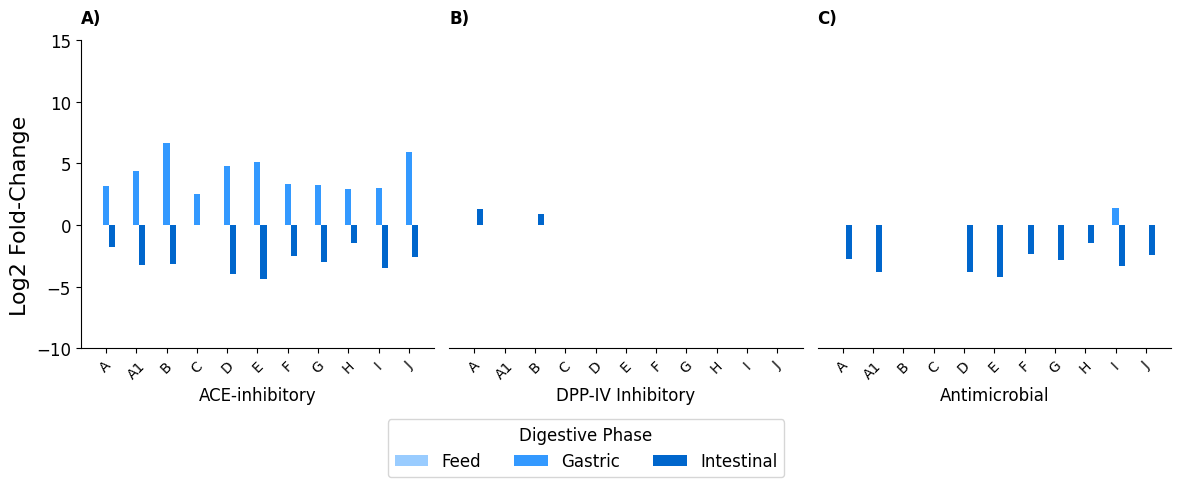

In [30]:

# Define shades of blue for each suffix
suffix_colors = {
    '_F': '#99CCFF',  # Light blue
    '_G': '#3399FF',  # Medium blue
    '_I': '#0066CC'   # Dark blue
}

suffix_labels = {'_F': 'Feed', '_G': 'Gastric', '_I': 'Intestinal'}

# Dynamically create subplot labels 'A', 'B', 'C', etc.
letters = string.ascii_uppercase[:len(function_list)]
if len(function_list)  == 4:
    n_cols = 2
    n_rows = 2
elif len(function_list)  < 4:
    n_cols = len(function_list) 
    n_rows = 1
elif len(function_list)  == 9:  
    # Create a figure with an appropriate number of subplots based on the function list
    n_cols = 3  # Set the number of columns to 4
    n_rows = 3  # Calculate the number of rows needed
elif len(function_list)  > 9:  
    # Create a figure with an appropriate number of subplots based on the function list
    n_cols = 4  # Set the number of columns to 4
    n_rows = math.ceil(len(function_list) / 4)
fig_size = 4 * n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_size, n_rows * 4.5))  # Adjust the figure size for 4 columns
plt.subplots_adjust(hspace=0.05, wspace=0.0)  # Adjust spacing between plots

for idx, (func, let) in enumerate(zip(function_list, letters)):
    filtered_combined_df = combined_df[combined_df['function'] == func]
    
    # Filter the DataFrame for non-NaN log2 fold change values
    filtered_combined_df = filtered_combined_df.dropna(subset=['log2_fold_change_abs'])
    
    # Separate data by suffix
    data_f = filtered_combined_df[filtered_combined_df['Base ID Group 2'].str.endswith('_F')].set_index('Base ID Group 2').drop_duplicates()
    data_g = filtered_combined_df[filtered_combined_df['Base ID Group 2'].str.endswith('_G')].set_index('Base ID Group 2').drop_duplicates()
    data_i = filtered_combined_df[filtered_combined_df['Base ID Group 2'].str.endswith('_I')].set_index('Base ID Group 2').drop_duplicates()
    # Prepare x-axis labels without the suffix, ensuring uniqueness
    x_labels = ['A','A1', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    
    # Align the data by x_labels using reindex
    data_f = data_f.reindex([label + '_F' for label in x_labels])['log2_fold_change_abs'].fillna(0)
    data_g = data_g.reindex([label + '_G' for label in x_labels])['log2_fold_change_abs'].fillna(0)
    data_i = data_i.reindex([label + '_I' for label in x_labels])['log2_fold_change_abs'].fillna(0)
    
    x = range(len(x_labels))  # Create x-axis positions
    if len(function_list)  < 4:
        ax = axes[idx]
    else:  
        ax = axes[idx // n_cols, idx % n_cols]

    # Calculate row and column index for 4 columns

    # Plotting three sets of bars
    ax.bar([pos - 0.2 for pos in x], data_f, width=0.2, color=suffix_colors['_F'], label=suffix_labels['_F'])
    ax.bar(x, data_g, width=0.2, color=suffix_colors['_G'], label=suffix_labels['_G'])
    ax.bar([pos + 0.2 for pos in x], data_i, width=0.2, color=suffix_colors['_I'], label=suffix_labels['_I'])
    
    # Set labels and title for each subplot
    ax.set_xlabel(f'{func}\n', fontsize=12)
    ax.set_ylim(-10, 15)  # Set y-axis limits

    # Set x-axis labels and rotation
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, fontsize=10)
    
    # Add subplot lettering in the top-left corner
    ax.text(0, 1.1, f'{let})', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')

    # Remove y-axis labels, ticks, and spine if not in column 0
    if idx % n_cols != 0:
        ax.set_yticklabels([])  # Remove y-axis labels
        ax.spines['left'].set_visible(False)  # Hide the left spine
        ax.tick_params(axis='y', which='both', left=False)  # Remove y-axis ticks
    else:
        # Set y-axis tick label font size if in column 0
        ax.tick_params(axis='y', labelsize=12)
      
    # Remove top and right spines for all plots
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add a common legend only once at the bottom center
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), title='Digestive Phase', fontsize=12, title_fontsize=12, ncol=3)

# Add a shared y-axis label
fig.supylabel('Log2 Fold-Change', fontsize=16, )

plt.tight_layout()  # Adjust layout to leave space for the legend
plt.show()
